In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt

In [8]:
r=0.05
sig=0.25
def mlmc_gbm(l,Nl,T=1,M=2):
    Nsteps=M**l
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    W=np.random.randn(Nsteps,Nl)*sqrt_dt
    P_l=calc_P_l(W,dt)
    sum1=sum(P_l)
    sum2=sum(P_l**2)
    
    if l==0:
        return np.array([sum1,sum2,sum1,sum2])
    else:
        Wnew=W[0::M,:]+W[1::M,:]
        P_lm1=calc_P_l(Wnew,M*dt)
        dP_l=P_l-P_lm1
        return np.array([sum(dP_l),sum(dP_l**2),sum1,sum2])

def calc_P_l(W,dt,X0=100,T=1):
    '''
    Inputs: W (matrix of Nsteps x Nl random numbers ~ N(0,1))
    Outputs: h(X) (payoff for each of the Nl paths)
    Calculate X for Nl paths over Nsteps 
    '''
    Nsteps,Nl=np.shape(W)
    X=X0*np.ones(Nl)
    for i in range(Nsteps):
        X+=r*X*dt + sig*X*W[i,:]
    X-=X0
    X[X<0]=0
    return np.exp(-0.05*T)*X

def N_opt(V,eps,L,M):
    '''
    This shouldn't change depending on alpha, but will change according to gamma.
    Beta is implicitly included in V, since Vl <= hl**beta.
    '''
    h=M**(np.arange(0,L+1))
    return np.ceil((2/eps**2)*sum(np.sqrt(V*h))*np.sqrt(V/h))
    
def mlmc(mlmc_fn,eps,N0=10**4,M=2,T=1):
    V=np.zeros(1)
    N=N0*np.ones(1)
    dN=N0*np.ones(1)
    sums=np.zeros((4,1))
    L=0
    sums[:,L]+=mlmc_fn(L,N0,T,M)
    
    while (sum(dN)!=0):
        V=np.maximum(sums[1,:]/N-(sums[0,:]/N)**2,0)
        Nl_new=N_opt(V,eps,L,M)
        dN=(np.maximum(0,Nl_new-N)).astype(int)
        N+=dN
        for l in range(L+1):
            if dN[l]>0:
                sums[:,l]+=mlmc_fn(l,dN[l],T,M)
                
        inc_L=False
        if L>2:
            if max(abs(sums[0,L-1])/(N[-2]*M),abs(sums[0,L])/N[-1])>(M-1)*eps/np.sqrt(2):
                inc_L=True
        else: 
            inc_L=True
            
        if inc_L:
                L+=1
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sums=np.concatenate((sums,np.zeros((4,1))),axis=1)
                sums[:,L]+=mlmc_fn(L,N0,T,M)
    
    return sums,N

def mlmc_variance(eps,mlmc_fn,M=2,T=1,N0=10**4):
    sums,N=mlmc(mlmc_fn,eps,N0,M,T)
    L=len(N)-1
    means_dp=sums[0,:]/N
    means_p=sums[2,:]/N

    V_dp=(sums[1,:]/N)-means_dp**2
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc=(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*eps**2
    cost_mc=2*sum(V_p*M**np.arange(L+1))
    
    fig,ax=plt.subplots(1,2)
    ax[0].plot(range(L+1),np.log(V_dp)/np.log(M),'k',range(L+1),np.log(Vp)/np.log(M),'b')
    ax[1].plot(range(L+1),np.log(means_dp)/np.log(M),'k',range(L+1),np.log(means_p)/np.log(M),'b')


def mlmc_complexity(mlmc_fn,eps,M=2,T=1,N0=10**4):
    fig,ax=plt.subplots(1,2)
    cost_mlmc=[]
    cost_mc=[]
    for e in eps:
        sums,N=mlmc(mlmc_fn,e,N0,M,T)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+sum(N[1:]*(M**np.arange(L)+M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]

    ax[0].semilogy(range(L+1),N)
    ax[0].set_xlabel('l')
    ax[0].set_ylabel('Nl')

    ax[1].loglog(eps,cost_mlmc,'k', eps, cost_mc,'b')
    ax[1].set_xlabel('$\epsilon$')
    ax[1].set_ylabel('$\epsilon^{2}$cost')

    

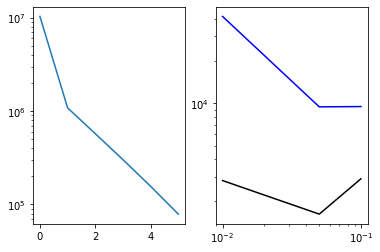

In [10]:
mlmc_complexity(mlmc_gbm,[0.00005,0.0001,0.0002,0.0005,0.001])

In [ ]:
#### Exact result according to BS formula
D1 =(r+sig**2/2)/sig
D2 = D1 - sig
print(100*norm.cdf(D1)-100*np.exp(-r)*norm.cdf(D2))
